In [1]:
import sys
import os
import time
import numpy as n

sys.path.append('cryoem/')
sys.path.append('cryoem/util')

from cryoem.cryoio import ctf
from cryoem.cryoio import mrc

from cryoem import cryoem
from cryoem import geom
from cryoem import cryoops
from cryoem import density

import numpy.fft as fourier

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams['figure.dpi'] = 100
plt.style.use(['dark_background'])

ModuleNotFoundError: No module named 'sparsemul'

In [7]:
defocus_min = 100000
defocus_max = 200000
defocus_ang_min = 1.4
defocus_ang_max = 0.2
accel_kv = 300
amp_contrast = 0.07
phase_shift = 0
scale = 1
spherical_abberr = 2.7

n_particles = 10
n_gridpoints = 8
snr = 0.5

kernel = 'lanczos'
ksize = int(6)
rad = 0.95
shift_sigma = 3.0

In [5]:
# Read the volume data and compute fft
vol,hdr = mrc.readMRC("6ac9TeMet_denmod.mrc", inc_header=True)
boxSize = int(vol.shape[0])
pxSize = (hdr['xlen']/hdr['nx'])

premult = cryoops.compute_premultiplier(boxSize, kernel, ksize) 

V = density.real_to_fspace(premult.reshape((1,1,-1)) * premult.reshape((1,-1,1)) * premult.reshape((-1,1,1)) * vol)

vol_f = fourier.fftshift(fourier.fft2(vol))

# plt.imshow(n.abs(testF), norm=LogNorm(vmin=5))



64


In [4]:
# compute particle-specific metadata (e.g. defocus)
particles = [{} for _ in range(n_particles)]
for p in particles:
    p['defocus'] = n.random.uniform(defocus_min, defocus_max)
    p['df_angle'] = n.random.uniform(defocus_ang_min, defocus_ang_max)

In [6]:
# Alignments

# Make empty blobs
pblob = n.zeros((n_particles, boxSize, boxSize), n.float32)
pblob_f = n.zeros((n_particles, boxSize, boxSize), n.complex64)

coords = n.zeros((boxSize**2,3))

angleIncrement = 360/n_gridpoints
rotationAngles = [i*angleIncrement for i in range(n_gridpoints+1)]


for p in range(n_particles):
    # Generate random orientation vector and get spherical angles
    pt = n.random.randn(3)
    pt /= n.linalg.norm(pt)
    psi = 2*n.pi*n.random.rand()
    
    # Compute Euler angles from a director vector
    # Output EA is tuple with phi, theta, psi
    EA = geom.genEA(pt)[0]
    EA[2] = psi
    
    shift = n.random.randn(2) * shift_sigma

    # Generate rotation matrix based on the Euler Angles
    R = geom.rotmat3D_EA(*EA)[:,0:2]
    slop = cryoops.compute_projection_matrix([R], boxSize, kernel, ksize, rad, 'rots')
    S = cryoops.compute_shift_phases(shift.reshape((1,2)), boxSize, rad)[0]
    
    D = slop.dot( V.reshape((-1,)) )
    D *= S

NameError: name 'V' is not defined

In [112]:
pt = n.random.randn(3)
pt /= n.linalg.norm(pt)
psi = 2*n.pi*n.random.rand()



EA = geom.genEA(pt)[0] 
EA[2] = psi

EA[2]

1.8383097259633785

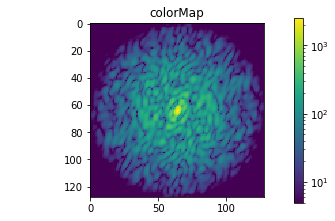

In [87]:
fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')

# plt.imshow(test)

ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

TypeError: compute_projection_matrix() missing 5 required positional arguments: 'projdirs', 'N', 'kern', 'kernsize', and 'rad'